# EE435 Final Project Video Generation and Enhancement with E2VID and ELIC

## Introduction
This project utilizes the E2VID and ELIC models to generate and enhance videos from small video recorded by event-based cameras. Event cameras capture pixel changes in light intensity, which reduces data redundancy and enhances detail in dynamic or low-light settings. We will reconstruct videos using E2VID to exploit the cameras' high temporal resolution, then enhance these videos with ELIC to improve visual quality in challenging lighting conditions. This streamlined approach aims to showcase the integration of event-based data reconstruction with advanced image enhancement techniques. The code is run in colab with L4 GPU and you can find complete code in [github](https://) The dependency is in $\texttt{requirements.txt}$ .

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cd /content/drive/My\ Drive/

In [3]:
!pip install -r /content/drive/MyDrive/EE435/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (

## Dataset

The data we used is part from Event Camera Dataset[1], a public event dataset. Unlike traditional cameras that capture entire frames at regular intervals, event cameras event cameras output data asynchronously. Each pixel in an event camera operates independently and continuously monitors changes in the light intensity at that pixel. Each event contains information about the pixel location $(x, y)$, the timestamp of the event $(t)$, and the polarity $(p)$ indicates whether the brightness of the pixel has increased or decreased.

## Data Visualization
As shown in the following code and image We correspond each point to the $(240, 180)$ image and record the different changes as time changes. The red points in the picture show a polarity of $1$. The blue color shows a polarity equal to $-1$.

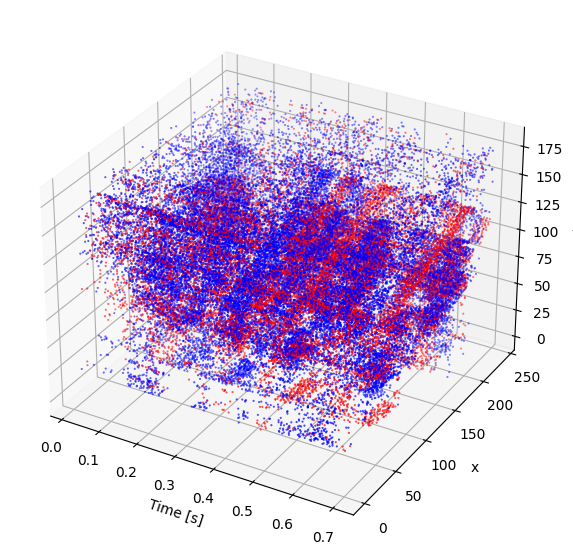

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

# Load the data from the provided file path
file_path = '/content/drive/MyDrive/EE435/EE435/dynamic_6dof.txt'
header = pd.read_csv(file_path, delim_whitespace=True, header=None)

# Extracting the columns from the dataframe
timestamps = np.array(header.iloc[:50000, 0])
x_coords = np.array(header.iloc[:50000, 1])
y_coords = np.array(header.iloc[:50000, 2])
p = np.array(header.iloc[:50000, 3])

# Plotting the data in a 3D scatter plot
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111, projection='3d')

# Creating the scatter plot
# Different colors for different classes
colors = np.where(p == 1, 'r', 'b')

# Plotting the points
ax.scatter(timestamps,x_coords, y_coords, c=colors, marker='.', s=1)
# Setting labels
ax.set_xlabel('Time [s]')
ax.set_ylabel('x')
ax.set_zlabel('y')

# Showing the plot
plt.show()


## Event to Video



The first step we used E2VID [2] to transform event data to video. Since E2VID requires high computational resources so we use provided trained model to transform event data to video. Our objective is to convert a continuous stream of events into a sequence of images, denoted as $\{I_k\}$. To accomplish this, we divide the incoming event stream into sequential (non-overlapping) spatio-temporal windows $\epsilon_k = \{e_i\}$. To enable the processing of the event stream using a convolutional recurrent network, we need to transform each $\epsilon_k$ into a fixed-size tensor representation $E_k$. After processing $E_k$ through the model, it is then mapped to the corresponding image $I_k$. The code of E2VID is uploaded to [github](https://).

**Visualization of frames**

The first row displays the reconstructed images, which are in black and white because the event camera captures only changes in brightness. The second row shows the tensor representations $E_k$ corresponding to the reconstructed images. It is evident that when event points in $E_k$ is more aggregated, the resulting image becomes clearer.

![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/frame_0000015119.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/frame_0019095297.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/frame_0057132658.png?raw=true)

![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/events_0000015119.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/events_0019095297.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/events_0057132658.png?raw=true)

## Video Compression
Finally, we utilize ELIC to compress and decompress the video file, aiming to minimize image loss during the ELIC processing. Although ELIC is primarily designed for image compression, we treat the video as a series of individual frames, allowing us to apply ELIC for both compression and decompression of the video.

In [3]:
# Copyright 2020 InterDigital Communications, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset


class ImageFolder(Dataset):
    """Load an image folder database. Training and testing image samples
    are respectively stored in separate directories:

    .. code-block::

        - rootdir/
            - train/
                - img000.png
                - img001.png
            - test/
                - img000.png
                - img001.png

    Args:
        root (string): root directory of the dataset
        transform (callable, optional): a function or transform that takes in a
            PIL image and returns a transformed version
        split (string): split mode ('train' or 'val')
    """

    def __init__(self, root, transform=None, split="train"):
        splitdir = Path(root) / split

        if not splitdir.is_dir():
            raise RuntimeError(f'Invalid directory "{root}"')

        self.samples = [f for f in splitdir.iterdir() if f.is_file()]

        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            img: `PIL.Image.Image` or transformed `PIL.Image.Image`.
        """
        img = Image.open(self.samples[index]).convert("RGB")
        if self.transform:
            return self.transform(img)
        return img

    def __len__(self):
        return len(self.samples)


In [4]:
import torch
from pathlib import Path
from typing import Dict, Tuple
import os


def DelfileList(path, filestarts='checkpoint_last'):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.startswith(filestarts):
                os.remove(os.path.join(root, file))

def load_checkpoint(filepath: Path) -> Dict[str, torch.Tensor]:
    checkpoint = torch.load(filepath, map_location="cpu")

    if "network" in checkpoint:
        state_dict = checkpoint["network"]
    elif "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    else:
        state_dict = checkpoint

    return state_dict

In [5]:
# Copyright 2020 InterDigital Communications, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor

from compressai.ops.parametrizers import NonNegativeParametrizer

__all__ = ["GDN", "GDN1"]


class GDN(nn.Module):
    r"""Generalized Divisive Normalization layer.

    Introduced in `"Density Modeling of Images Using a Generalized Normalization
    Transformation" <https://arxiv.org/abs/1511.06281>`_,
    by Balle Johannes, Valero Laparra, and Eero P. Simoncelli, (2016).

    .. math::

       y[i] = \frac{x[i]}{\sqrt{\beta[i] + \sum_j(\gamma[j, i] * x[j]^2)}}

    """

    def __init__(
        self,
        in_channels: int,
        inverse: bool = False,
        beta_min: float = 1e-6,
        gamma_init: float = 0.1,
    ):
        super().__init__()

        beta_min = float(beta_min)
        gamma_init = float(gamma_init)
        self.inverse = bool(inverse)

        self.beta_reparam = NonNegativeParametrizer(minimum=beta_min)
        beta = torch.ones(in_channels)
        beta = self.beta_reparam.init(beta)
        self.beta = nn.Parameter(beta)

        self.gamma_reparam = NonNegativeParametrizer()
        gamma = gamma_init * torch.eye(in_channels)
        gamma = self.gamma_reparam.init(gamma)
        self.gamma = nn.Parameter(gamma)

    def forward(self, x: Tensor) -> Tensor:
        _, C, _, _ = x.size()

        beta = self.beta_reparam(self.beta)
        gamma = self.gamma_reparam(self.gamma)
        gamma = gamma.reshape(C, C, 1, 1)
        norm = F.conv2d(x ** 2, gamma, beta)

        if self.inverse:
            norm = torch.sqrt(norm)
        else:
            norm = torch.rsqrt(norm)

        out = x * norm

        return out


class GDN1(GDN):
    r"""Simplified GDN layer.

    Introduced in `"Computationally Efficient Neural Image Compression"
    <http://arxiv.org/abs/1912.08771>`_, by Johnston Nick, Elad Eban, Ariel
    Gordon, and Johannes Ballé, (2019).

    .. math::

        y[i] = \frac{x[i]}{\beta[i] + \sum_j(\gamma[j, i] * |x[j]|}

    """

    def forward(self, x: Tensor) -> Tensor:
        _, C, _, _ = x.size()

        beta = self.beta_reparam(self.beta)
        gamma = self.gamma_reparam(self.gamma)
        gamma = gamma.reshape(C, C, 1, 1)
        norm = F.conv2d(torch.abs(x), gamma, beta)

        if not self.inverse:
            norm = 1.0 / norm

        out = x * norm

        return out


In [6]:
# Copyright 2020 InterDigital Communications, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Any

import torch
import torch.nn as nn

from torch import Tensor

__all__ = [
    "AttentionBlock",
    "MaskedConv2d",
    "CheckboardMaskedConv2d",
    "ResidualBlock",
    "ResidualBlockUpsample",
    "ResidualBlockWithStride",
    "conv3x3",
    "subpel_conv3x3",
]


class MaskedConv2d(nn.Conv2d):
    r"""Masked 2D convolution implementation, mask future "unseen" pixels.
    Useful for building auto-regressive network components.

    Introduced in `"Conditional Image Generation with PixelCNN Decoders"
    <https://arxiv.org/abs/1606.05328>`_.

    Inherits the same arguments as a `nn.Conv2d`. Use `mask_type='A'` for the
    first layer (which also masks the "current pixel"), `mask_type='B'` for the
    following layers.
    """

    def __init__(self, *args: Any, mask_type: str = "A", **kwargs: Any):
        super().__init__(*args, **kwargs)

        if mask_type not in ("A", "B"):
            raise ValueError(f'Invalid "mask_type" value "{mask_type}"')

        self.register_buffer("mask", torch.ones_like(self.weight.data))
        _, _, h, w = self.mask.size()
        self.mask[:, :, h // 2, w // 2 + (mask_type == "B") :] = 0
        self.mask[:, :, h // 2 + 1 :] = 0

    def forward(self, x: Tensor) -> Tensor:
        # TODO(begaintj): weight assigment is not supported by torchscript
        self.weight.data *= self.mask
        return super().forward(x)

class CheckboardMaskedConv2d(nn.Conv2d):
    """
    if kernel_size == (5, 5)
    then mask:
        [[0., 1., 0., 1., 0.],
        [1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0.],
        [1., 0., 1., 0., 1.],
        [0., 1., 0., 1., 0.]]
    0: non-anchor
    1: anchor
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.register_buffer("mask", torch.zeros_like(self.weight.data))

        self.mask[:, :, 0::2, 1::2] = 1
        self.mask[:, :, 1::2, 0::2] = 1

    def forward(self, x):
        self.weight.data *= self.mask
        out = super().forward(x)

        return out

def conv3x3(in_ch: int, out_ch: int, stride: int = 1) -> nn.Module:
    """3x3 convolution with padding."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)


def subpel_conv3x3(in_ch: int, out_ch: int, r: int = 1) -> nn.Sequential:
    """3x3 sub-pixel convolution for up-sampling."""
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch * r ** 2, kernel_size=3, padding=1), nn.PixelShuffle(r)
    )


def conv1x1(in_ch: int, out_ch: int, stride: int = 1) -> nn.Module:
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)


class ResidualBlockWithStride(nn.Module):
    """Residual block with a stride on the first convolution.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
        stride (int): stride value (default: 2)
    """

    def __init__(self, in_ch: int, out_ch: int, stride: int = 2):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch, stride=stride)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.conv2 = conv3x3(out_ch, out_ch)
        self.gdn = GDN(out_ch)
        if stride != 1 or in_ch != out_ch:
            self.skip = conv1x1(in_ch, out_ch, stride=stride)
        else:
            self.skip = None

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.leaky_relu(out)
        out = self.conv2(out)
        out = self.gdn(out)

        if self.skip is not None:
            identity = self.skip(x)

        out += identity
        return out


class ResidualBlockUpsample(nn.Module):
    """Residual block with sub-pixel upsampling on the last convolution.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
        upsample (int): upsampling factor (default: 2)
    """

    def __init__(self, in_ch: int, out_ch: int, upsample: int = 2):
        super().__init__()
        self.subpel_conv = subpel_conv3x3(in_ch, out_ch, upsample)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.conv = conv3x3(out_ch, out_ch)
        self.igdn = GDN(out_ch, inverse=True)
        self.upsample = subpel_conv3x3(in_ch, out_ch, upsample)

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.subpel_conv(x)
        out = self.leaky_relu(out)
        out = self.conv(out)
        out = self.igdn(out)
        identity = self.upsample(x)
        out += identity
        return out


class ResidualBlock(nn.Module):
    """Simple residual block with two 3x3 convolutions.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
    """

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        self.conv2 = conv3x3(out_ch, out_ch)
        if in_ch != out_ch:
            self.skip = conv1x1(in_ch, out_ch)
        else:
            self.skip = None

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.leaky_relu(out)
        out = self.conv2(out)
        out = self.leaky_relu(out)

        if self.skip is not None:
            identity = self.skip(x)

        out = out + identity
        return out


class AttentionBlock(nn.Module):
    """Self attention block.

    Simplified variant from `"Learned Image Compression with
    Discretized Gaussian Mixture Likelihoods and Attention Modules"
    <https://arxiv.org/abs/2001.01568>`_, by Zhengxue Cheng, Heming Sun, Masaru
    Takeuchi, Jiro Katto.

    Args:
        N (int): Number of channels)
    """

    def __init__(self, N: int):
        super().__init__()

        class ResidualUnit(nn.Module):
            """Simple residual unit."""

            def __init__(self):
                super().__init__()
                self.conv = nn.Sequential(
                    conv1x1(N, N // 2),
                    nn.ReLU(inplace=True),
                    conv3x3(N // 2, N // 2),
                    nn.ReLU(inplace=True),
                    conv1x1(N // 2, N),
                )
                self.relu = nn.ReLU(inplace=True)

            def forward(self, x: Tensor) -> Tensor:
                identity = x
                out = self.conv(x)
                out += identity
                out = self.relu(out)
                return out

        self.conv_a = nn.Sequential(ResidualUnit(), ResidualUnit(), ResidualUnit())

        self.conv_b = nn.Sequential(
            ResidualUnit(),
            ResidualUnit(),
            ResidualUnit(),
            conv1x1(N, N),
        )

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        a = self.conv_a(x)
        b = self.conv_b(x)
        out = a * torch.sigmoid(b)
        out += identity
        return out


In [7]:
"""
A simple test algorithm to rewrite the network
"""
import math
import torch
import torch.nn as nn
from torch import Tensor
from timm.models.layers import trunc_normal_

from compressai.models.priors import CompressionModel, GaussianConditional
from compressai.ops import ste_round
from compressai.models.utils import conv, deconv, update_registered_buffers

from thop import profile
from ptflops import get_model_complexity_info

# From Balle's tensorflow compression examples
SCALES_MIN = 0.11
SCALES_MAX = 256
SCALES_LEVELS = 64
def get_scale_table(min=SCALES_MIN, max=SCALES_MAX, levels=SCALES_LEVELS):
    return torch.exp(torch.linspace(math.log(min), math.log(max), levels))

def conv1x1(in_ch: int, out_ch: int, stride: int = 1) -> nn.Module:
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)

class ResidualBottleneckBlock(nn.Module):
    """Simple residual block with two 3x3 convolutions.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
    """

    def __init__(self, in_ch: int):
        super().__init__()
        self.conv1 = conv1x1(in_ch, in_ch//2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(in_ch//2, in_ch//2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = conv1x1(in_ch//2, in_ch)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.conv3(out)

        out = out + identity
        return out


class Quantizer():
    def quantize(self, inputs, quantize_type="noise"):
        if quantize_type == "noise":
            half = float(0.5)
            noise = torch.empty_like(inputs).uniform_(-half, half)
            inputs = inputs + noise
            return inputs
        elif quantize_type == "ste":
            return torch.round(inputs) - inputs.detach() + inputs
        else:
            return torch.round(inputs)

class TestModel(CompressionModel):

    def __init__(self, N=192, M=320, num_slices=5, **kwargs):
        super().__init__(entropy_bottleneck_channels=192)
        self.N = int(N)
        self.M = int(M)
        self.num_slices = num_slices

        """
             N: channel number of main network
             M: channnel number of latent space

        """
        self.groups = [0, 16, 16, 32, 64, 192] #support depth
        self.g_a = nn.Sequential(
            conv(3, N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            conv(N, N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            AttentionBlock(N),
            conv(N, N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            conv(N, M),
            AttentionBlock(M),
        )

        self.g_s = nn.Sequential(
            AttentionBlock(M),
            deconv(M, N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            deconv(N, N),
            AttentionBlock(N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            deconv(N, N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            ResidualBottleneckBlock(N),
            deconv(N, 3),
        )

        self.h_a = nn.Sequential(
            conv3x3(M, N),
            nn.ReLU(inplace=True),
            conv(N, N),
            nn.ReLU(inplace=True),
            conv(N, N),
        )

        self.h_s = nn.Sequential(
            deconv(N, N),
            nn.ReLU(inplace=True),
            deconv(N, N*3//2),
            nn.ReLU(inplace=True),
            conv3x3(N*3//2, 2*M),
        )

        self.cc_transforms = nn.ModuleList(
            nn.Sequential(
                conv(self.groups[min(1, i) if i > 0 else 0] + self.groups[i if i > 1 else 0], 224, stride=1,
                     kernel_size=5),
                nn.ReLU(inplace=True),
                conv(224, 128, stride=1, kernel_size=5),
                nn.ReLU(inplace=True),
                conv(128, self.groups[i + 1]*2, stride=1, kernel_size=5),
            ) for i in range(1,  num_slices)
        ) ## from https://github.com/tensorflow/compression/blob/master/models/ms2020.py

        self.context_prediction = nn.ModuleList(
            CheckboardMaskedConv2d(
            self.groups[i+1], 2*self.groups[i+1], kernel_size=5, padding=2, stride=1
            ) for i in range(num_slices)
        )## from https://github.com/JiangWeibeta/Checkerboard-Context-Model-for-Efficient-Learned-Image-Compression/blob/main/version2/layers/CheckerboardContext.py

        self.ParamAggregation = nn.ModuleList(
            nn.Sequential(
                conv1x1(640 + self.groups[i+1 if i > 0 else 0] * 2 + self.groups[
                        i + 1] * 2, 640),
                nn.ReLU(inplace=True),
                conv1x1(640, 512),
                nn.ReLU(inplace=True),
                conv1x1(512, self.groups[i + 1]*2),
            ) for i in range(num_slices)
        ) ##from checkboard "Checkerboard Context Model for Efficient Learned Image Compression"" gep网络参数

        self.quantizer = Quantizer()

        self.gaussian_conditional = GaussianConditional(None)


    @property
    def downsampling_factor(self) -> int:
        return 2 ** (4 + 2)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=.02)
                if isinstance(m, nn.Linear) and m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)


    def forward(self, x, noisequant=False):
        y = self.g_a(x)
        B, C, H, W = y.size() ## The shape of y to generate the mask

        z = self.h_a(y)
        z_hat, z_likelihoods = self.entropy_bottleneck(z)
        if not noisequant:
            z_offset = self.entropy_bottleneck._get_medians()
            z_tmp = z - z_offset
            z_hat = ste_round(z_tmp) + z_offset

        latent_means, latent_scales = self.h_s(z_hat).chunk(2, 1)

        anchor = torch.zeros_like(y).to(x.device)
        non_anchor = torch.zeros_like(y).to(x.device)

        anchor[:, :, 0::2, 0::2] = y[:, :, 0::2, 0::2]
        anchor[:, :, 1::2, 1::2] = y[:, :, 1::2, 1::2]
        non_anchor[:, :, 0::2, 1::2] = y[:, :, 0::2, 1::2]
        non_anchor[:, :, 1::2, 0::2] = y[:, :, 1::2, 0::2]

        y_slices = torch.split(y, self.groups[1:], 1)

        anchor_split = torch.split(anchor, self.groups[1:], 1)
        non_anchor_split = torch.split(non_anchor, self.groups[1:], 1)
        ctx_params_anchor_split = torch.split(torch.zeros(B, C * 2, H, W).to(x.device),
                                              [2 * i for i in self.groups[1:]], 1)
        y_hat_slices = []
        y_hat_slices_for_gs = []
        y_likelihood = []
        for slice_index, y_slice in enumerate(y_slices):
            if slice_index == 0:
                support_slices = []
            elif slice_index == 1:
                support_slices = y_hat_slices[0]
                support_slices_ch = self.cc_transforms[slice_index-1](support_slices)
                support_slices_ch_mean, support_slices_ch_scale = support_slices_ch.chunk(2, 1)
            else:
                support_slices = torch.concat([y_hat_slices[0], y_hat_slices[slice_index-1]], dim=1)
                support_slices_ch = self.cc_transforms[slice_index-1](support_slices)
                support_slices_ch_mean, support_slices_ch_scale = support_slices_ch.chunk(2, 1)
            ##support mean and scale
            support = torch.concat([latent_means, latent_scales], dim=1) if slice_index == 0 else torch.concat(
                [support_slices_ch_mean, support_slices_ch_scale, latent_means, latent_scales], dim=1)
            ### checkboard process 1
            y_anchor = anchor_split[slice_index]
            means_anchor, scales_anchor, = self.ParamAggregation[slice_index](
                torch.concat([ctx_params_anchor_split[slice_index], support], dim=1)).chunk(2, 1)

            scales_hat_split = torch.zeros_like(y_anchor).to(x.device)
            means_hat_split = torch.zeros_like(y_anchor).to(x.device)

            scales_hat_split[:, :, 0::2, 0::2] = scales_anchor[:, :, 0::2, 0::2]
            scales_hat_split[:, :, 1::2, 1::2] = scales_anchor[:, :, 1::2, 1::2]
            means_hat_split[:, :, 0::2, 0::2] = means_anchor[:, :, 0::2, 0::2]
            means_hat_split[:, :, 1::2, 1::2] = means_anchor[:, :, 1::2, 1::2]
            if noisequant:
                y_anchor_quantilized = self.quantizer.quantize(y_anchor, "noise")
                y_anchor_quantilized_for_gs = self.quantizer.quantize(y_anchor, "ste")
            else:
                y_anchor_quantilized = self.quantizer.quantize(y_anchor - means_anchor, "ste") + means_anchor
                y_anchor_quantilized_for_gs = self.quantizer.quantize(y_anchor - means_anchor, "ste") + means_anchor


            y_anchor_quantilized[:, :, 0::2, 1::2] = 0
            y_anchor_quantilized[:, :, 1::2, 0::2] = 0
            y_anchor_quantilized_for_gs[:, :, 0::2, 1::2] = 0
            y_anchor_quantilized_for_gs[:, :, 1::2, 0::2] = 0

            ### checkboard process 2
            masked_context = self.context_prediction[slice_index](y_anchor_quantilized)
            means_non_anchor, scales_non_anchor = self.ParamAggregation[slice_index](
                torch.concat([masked_context, support], dim=1)).chunk(2, 1)

            scales_hat_split[:, :, 0::2, 1::2] = scales_non_anchor[:, :, 0::2, 1::2]
            scales_hat_split[:, :, 1::2, 0::2] = scales_non_anchor[:, :, 1::2, 0::2]
            means_hat_split[:, :, 0::2, 1::2] = means_non_anchor[:, :, 0::2, 1::2]
            means_hat_split[:, :, 1::2, 0::2] = means_non_anchor[:, :, 1::2, 0::2]
            # entropy estimation
            _, y_slice_likelihood = self.gaussian_conditional(y_slice, scales_hat_split, means=means_hat_split)

            y_non_anchor = non_anchor_split[slice_index]
            if noisequant:
                y_non_anchor_quantilized = self.quantizer.quantize(y_non_anchor, "noise")
                y_non_anchor_quantilized_for_gs = self.quantizer.quantize(y_non_anchor, "ste")
            else:
                y_non_anchor_quantilized = self.quantizer.quantize(y_non_anchor - means_non_anchor,
                                                                          "ste") + means_non_anchor
                y_non_anchor_quantilized_for_gs = self.quantizer.quantize(y_non_anchor - means_non_anchor,
                                                                          "ste") + means_non_anchor

            y_non_anchor_quantilized[:, :, 0::2, 0::2] = 0
            y_non_anchor_quantilized[:, :, 1::2, 1::2] = 0
            y_non_anchor_quantilized_for_gs[:, :, 0::2, 0::2] = 0
            y_non_anchor_quantilized_for_gs[:, :, 1::2, 1::2] = 0

            y_hat_slice = y_anchor_quantilized + y_non_anchor_quantilized
            y_hat_slice_for_gs = y_anchor_quantilized_for_gs + y_non_anchor_quantilized_for_gs
            y_hat_slices.append(y_hat_slice)
            ### ste for synthesis model
            y_hat_slices_for_gs.append(y_hat_slice_for_gs)
            y_likelihood.append(y_slice_likelihood)

        y_likelihoods = torch.cat(y_likelihood, dim=1)
        """
        use STE(y) as the input of synthesizer
        """
        y_hat = torch.cat(y_hat_slices_for_gs, dim=1)
        x_hat = self.g_s(y_hat)

        return {
            "x_hat": x_hat,
            "likelihoods": {"y": y_likelihoods, "z": z_likelihoods},
        }

    def load_state_dict(self, state_dict):
        update_registered_buffers(
            self.gaussian_conditional,
            "gaussian_conditional",
            ["_quantized_cdf", "_offset", "_cdf_length", "scale_table"],
            state_dict,
        )
        super().load_state_dict(state_dict)
    @classmethod
    def from_state_dict(cls, state_dict):
        """Return a new model instance from `state_dict`."""
        net = cls()
        net.load_state_dict(state_dict)
        return net

    def update(self, scale_table=None, force=False):
        if scale_table is None:
            scale_table = get_scale_table()
        updated = self.gaussian_conditional.update_scale_table(scale_table, force=force)
        updated |= super().update(force=force)
        return updated

    @classmethod
    def from_state_dict(cls, state_dict):
        """Return a new model instance from `state_dict`."""
        net = cls()
        net.load_state_dict(state_dict)
        return net

    def compress(self, x):
        import time
        y_enc_start = time.time()
        y = self.g_a(x)
        y_enc = time.time() - y_enc_start
        B, C, H, W = y.size()  ## The shape of y to generate the mask

        z_enc_start = time.time()
        z = self.h_a(y)
        z_enc = time.time() - z_enc_start
        z_strings = self.entropy_bottleneck.compress(z)
        z_hat = self.entropy_bottleneck.decompress(z_strings, z.size()[-2:])

        z_dec_start = time.time()
        latent_means, latent_scales = self.h_s(z_hat).chunk(2, 1)
        z_dec = time.time() - z_dec_start

        y_slices = torch.split(y, self.groups[1:], 1)

        ctx_params_anchor_split = torch.split(torch.zeros(B, C * 2, H, W).to(x.device), [2 * i for i in self.groups[1:]], 1)

        y_strings = []
        y_hat_slices = []
        params_start = time.time()
        for slice_index, y_slice in enumerate(y_slices):
            if slice_index == 0:
                support_slices = []
            elif slice_index == 1:
                support_slices = y_hat_slices[0]
                support_slices_ch = self.cc_transforms[slice_index - 1](support_slices)
                support_slices_ch_mean, support_slices_ch_scale = support_slices_ch.chunk(2, 1)

            else:
                support_slices = torch.concat([y_hat_slices[0], y_hat_slices[slice_index - 1]], dim=1)
                support_slices_ch = self.cc_transforms[slice_index - 1](support_slices)
                support_slices_ch_mean, support_slices_ch_scale = support_slices_ch.chunk(2, 1)
            ##support mean and scale
            support = torch.concat([latent_means, latent_scales], dim=1) if slice_index == 0 else torch.concat(
                [support_slices_ch_mean, support_slices_ch_scale, latent_means, latent_scales], dim=1)
            ### checkboard process 1
            y_anchor = y_slices[slice_index].clone()
            means_anchor, scales_anchor, = self.ParamAggregation[slice_index](
                torch.concat([ctx_params_anchor_split[slice_index], support], dim=1)).chunk(2, 1)

            B_anchor, C_anchor, H_anchor, W_anchor = y_anchor.size()

            y_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor//2).to(x.device)
            means_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor//2).to(x.device)
            scales_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor // 2).to(x.device)
            y_anchor_decode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor).to(x.device)

            y_anchor_encode[:, :, 0::2, :] = y_anchor[:, :, 0::2, 0::2]
            y_anchor_encode[:, :, 1::2, :] = y_anchor[:, :, 1::2, 1::2]
            means_anchor_encode[:, :, 0::2, :] = means_anchor[:, :, 0::2, 0::2]
            means_anchor_encode[:, :, 1::2, :] = means_anchor[:, :, 1::2, 1::2]
            scales_anchor_encode[:, :, 0::2, :] = scales_anchor[:, :, 0::2, 0::2]
            scales_anchor_encode[:, :, 1::2, :] = scales_anchor[:, :, 1::2, 1::2]

            indexes_anchor = self.gaussian_conditional.build_indexes(scales_anchor_encode)
            anchor_strings = self.gaussian_conditional.compress(y_anchor_encode, indexes_anchor, means=means_anchor_encode)
            anchor_quantized = self.gaussian_conditional.decompress(anchor_strings, indexes_anchor, means=means_anchor_encode)
            y_anchor_decode[:, :, 0::2, 0::2] = anchor_quantized[:, :, 0::2, :]
            y_anchor_decode[:, :, 1::2, 1::2] = anchor_quantized[:, :, 1::2, :]


            ### checkboard process 2
            masked_context = self.context_prediction[slice_index](y_anchor_decode)
            means_non_anchor, scales_non_anchor = self.ParamAggregation[slice_index](
                torch.concat([masked_context, support], dim=1)).chunk(2, 1)

            y_non_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor // 2).to(x.device)
            means_non_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor // 2).to(x.device)
            scales_non_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor // 2).to(x.device)

            non_anchor = y_slices[slice_index].clone()
            y_non_anchor_encode[:, :, 0::2, :] = non_anchor[:, :, 0::2, 1::2]
            y_non_anchor_encode[:, :, 1::2, :] = non_anchor[:, :, 1::2, 0::2]
            means_non_anchor_encode[:, :, 0::2, :] = means_non_anchor[:, :, 0::2, 1::2]
            means_non_anchor_encode[:, :, 1::2, :] = means_non_anchor[:, :, 1::2, 0::2]
            scales_non_anchor_encode[:, :, 0::2, :] = scales_non_anchor[:, :, 0::2, 1::2]
            scales_non_anchor_encode[:, :, 1::2, :] = scales_non_anchor[:, :, 1::2, 0::2]

            indexes_non_anchor = self.gaussian_conditional.build_indexes(scales_non_anchor_encode)
            non_anchor_strings = self.gaussian_conditional.compress(y_non_anchor_encode, indexes_non_anchor,
                                                                    means=means_non_anchor_encode)

            non_anchor_quantized = self.gaussian_conditional.decompress(non_anchor_strings, indexes_non_anchor,
                                                                        means=means_non_anchor_encode)

            y_non_anchor_quantized = torch.zeros_like(means_anchor)
            y_non_anchor_quantized[:, :, 0::2, 1::2] = non_anchor_quantized[:, :, 0::2, :]
            y_non_anchor_quantized[:, :, 1::2, 0::2] = non_anchor_quantized[:, :, 1::2, :]

            y_slice_hat = y_anchor_decode + y_non_anchor_quantized
            y_hat_slices.append(y_slice_hat)

            y_strings.append([anchor_strings, non_anchor_strings])

        params_time = time.time() - params_start
        return {"strings": [y_strings, z_strings], "shape": z.size()[-2:],
                "time": {'y_enc': y_enc, "z_enc": z_enc, "z_dec": z_dec, "params": params_time}}


    def decompress(self, strings, shape):
        assert isinstance(strings, list) and len(strings) == 2

        # FIXME: we don't respect the default entropy coder and directly call thse
        # range ANS decoder

        z_hat = self.entropy_bottleneck.decompress(strings[1], shape)
        B, _, _, _ = z_hat.size()

        latent_means, latent_scales = self.h_s(z_hat).chunk(2, 1)

        y_shape = [z_hat.shape[2] * 4, z_hat.shape[3] * 4]
        y_strings = strings[0]

        ctx_params_anchor = torch.zeros((B, self.M*2, z_hat.shape[2] * 4, z_hat.shape[3] * 4)).to(z_hat.device)
        ctx_params_anchor_split = torch.split(ctx_params_anchor, [2 * i for i in self.groups[1:]], 1)


        y_hat_slices = []
        for slice_index in range(len(self.groups) - 1):
            if slice_index == 0:
                support_slices = []
            elif slice_index == 1:
                support_slices = y_hat_slices[0]
                support_slices_ch = self.cc_transforms[slice_index - 1](support_slices)
                support_slices_ch_mean, support_slices_ch_scale = support_slices_ch.chunk(2, 1)

            else:
                support_slices = torch.concat([y_hat_slices[0], y_hat_slices[slice_index - 1]], dim=1)
                support_slices_ch = self.cc_transforms[slice_index - 1](support_slices)
                support_slices_ch_mean, support_slices_ch_scale = support_slices_ch.chunk(2, 1)
            ##support mean and scale
            support = torch.concat([latent_means, latent_scales], dim=1) if slice_index == 0 else torch.concat(
                [support_slices_ch_mean, support_slices_ch_scale, latent_means, latent_scales], dim=1)
            ### checkboard process 1
            means_anchor, scales_anchor, = self.ParamAggregation[slice_index](
                torch.concat([ctx_params_anchor_split[slice_index], support], dim=1)).chunk(2, 1)

            B_anchor, C_anchor, H_anchor, W_anchor = means_anchor.size()

            means_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor // 2).to(z_hat.device)
            scales_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor // 2).to(z_hat.device)
            y_anchor_decode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor).to(z_hat.device)

            means_anchor_encode[:, :, 0::2, :] = means_anchor[:, :, 0::2, 0::2]
            means_anchor_encode[:, :, 1::2, :] = means_anchor[:, :, 1::2, 1::2]
            scales_anchor_encode[:, :, 0::2, :] = scales_anchor[:, :, 0::2, 0::2]
            scales_anchor_encode[:, :, 1::2, :] = scales_anchor[:, :, 1::2, 1::2]

            indexes_anchor = self.gaussian_conditional.build_indexes(scales_anchor_encode)
            anchor_strings = y_strings[slice_index][0]
            anchor_quantized = self.gaussian_conditional.decompress(anchor_strings, indexes_anchor,
                                                                    means=means_anchor_encode)

            y_anchor_decode[:, :, 0::2, 0::2] = anchor_quantized[:, :, 0::2, :]
            y_anchor_decode[:, :, 1::2, 1::2] = anchor_quantized[:, :, 1::2, :]

            ### checkboard process 2
            masked_context = self.context_prediction[slice_index](y_anchor_decode)
            means_non_anchor, scales_non_anchor = self.ParamAggregation[slice_index](
                torch.concat([masked_context, support], dim=1)).chunk(2, 1)

            means_non_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor // 2).to(z_hat.device)
            scales_non_anchor_encode = torch.zeros(B_anchor, C_anchor, H_anchor, W_anchor // 2).to(z_hat.device)

            means_non_anchor_encode[:, :, 0::2, :] = means_non_anchor[:, :, 0::2, 1::2]
            means_non_anchor_encode[:, :, 1::2, :] = means_non_anchor[:, :, 1::2, 0::2]
            scales_non_anchor_encode[:, :, 0::2, :] = scales_non_anchor[:, :, 0::2, 1::2]
            scales_non_anchor_encode[:, :, 1::2, :] = scales_non_anchor[:, :, 1::2, 0::2]

            indexes_non_anchor = self.gaussian_conditional.build_indexes(scales_non_anchor_encode)
            non_anchor_strings = y_strings[slice_index][1]
            non_anchor_quantized = self.gaussian_conditional.decompress(non_anchor_strings, indexes_non_anchor,
                                                                        means=means_non_anchor_encode)

            y_non_anchor_quantized = torch.zeros_like(means_anchor)
            y_non_anchor_quantized[:, :, 0::2, 1::2] = non_anchor_quantized[:, :, 0::2, :]
            y_non_anchor_quantized[:, :, 1::2, 0::2] = non_anchor_quantized[:, :, 1::2, :]

            y_slice_hat = y_anchor_decode + y_non_anchor_quantized
            y_hat_slices.append(y_slice_hat)
        y_hat = torch.cat(y_hat_slices, dim=1)

        import time
        y_dec_start = time.time()
        x_hat = self.g_s(y_hat).clamp_(0, 1)
        y_dec = time.time() - y_dec_start

        return {"x_hat": x_hat, "time":{"y_dec": y_dec}}

    def inference(self, x):
        import time
        y_enc_start = time.time()
        y = self.g_a(x)
        y_enc = time.time() - y_enc_start
        B, C, H, W = y.size()  ## The shape of y to generate the mask

        z_enc_start = time.time()
        z = self.h_a(y)
        z_enc = time.time() - z_enc_start
        z_hat, z_likelihoods = self.entropy_bottleneck(z)
        z_offset = self.entropy_bottleneck._get_medians()
        z_tmp = z - z_offset
        z_hat = ste_round(z_tmp) + z_offset

        z_dec_start = time.time()
        latent_means, latent_scales = self.h_s(z_hat).chunk(2, 1)
        z_dec = time.time() - z_dec_start

        anchor = torch.zeros_like(y).to(x.device)
        non_anchor = torch.zeros_like(y).to(x.device)

        anchor[:, :, 0::2, 0::2] = y[:, :, 0::2, 0::2]
        anchor[:, :, 1::2, 1::2] = y[:, :, 1::2, 1::2]
        non_anchor[:, :, 0::2, 1::2] = y[:, :, 0::2, 1::2]
        non_anchor[:, :, 1::2, 0::2] = y[:, :, 1::2, 0::2]

        y_slices = torch.split(y, self.groups[1:], 1)

        anchor_split = torch.split(anchor, self.groups[1:], 1)
        non_anchor_split = torch.split(non_anchor, self.groups[1:], 1)
        ctx_params_anchor_split = torch.split(torch.zeros(B, C * 2, H, W).to(x.device),
                                              [2 * i for i in self.groups[1:]], 1)
        y_hat_slices = []
        y_likelihood = []
        params_start = time.time()
        for slice_index, y_slice in enumerate(y_slices):
            if slice_index == 0:
                support_slices = []
            elif slice_index == 1:
                support_slices = y_hat_slices[0]
                support_slices_ch = self.cc_transforms[slice_index - 1](support_slices)
                support_slices_ch_mean, support_slices_ch_scale = support_slices_ch.chunk(2, 1)

            else:
                support_slices = torch.concat([y_hat_slices[0], y_hat_slices[slice_index - 1]], dim=1)
                support_slices_ch = self.cc_transforms[slice_index - 1](support_slices)
                support_slices_ch_mean, support_slices_ch_scale = support_slices_ch.chunk(2, 1)
            ##support mean and scale
            support = torch.concat([latent_means, latent_scales], dim=1) if slice_index == 0 else torch.concat(
                [support_slices_ch_mean, support_slices_ch_scale, latent_means, latent_scales], dim=1)
            ### checkboard process 1
            y_anchor = anchor_split[slice_index]
            means_anchor, scales_anchor, = self.ParamAggregation[slice_index](
                torch.concat([ctx_params_anchor_split[slice_index], support], dim=1)).chunk(2, 1)

            scales_hat_split = torch.zeros_like(y_anchor).to(x.device)
            means_hat_split = torch.zeros_like(y_anchor).to(x.device)

            scales_hat_split[:, :, 0::2, 0::2] = scales_anchor[:, :, 0::2, 0::2]
            scales_hat_split[:, :, 1::2, 1::2] = scales_anchor[:, :, 1::2, 1::2]
            means_hat_split[:, :, 0::2, 0::2] = means_anchor[:, :, 0::2, 0::2]
            means_hat_split[:, :, 1::2, 1::2] = means_anchor[:, :, 1::2, 1::2]

            y_anchor_quantilized_for_gs = self.quantizer.quantize(y_anchor - means_anchor, "ste") + means_anchor

            y_anchor_quantilized_for_gs[:, :, 0::2, 1::2] = 0
            y_anchor_quantilized_for_gs[:, :, 1::2, 0::2] = 0

            ### checkboard process 2
            masked_context = self.context_prediction[slice_index](y_anchor_quantilized_for_gs)
            means_non_anchor, scales_non_anchor = self.ParamAggregation[slice_index](
                torch.concat([masked_context, support], dim=1)).chunk(2, 1)

            scales_hat_split[:, :, 0::2, 1::2] = scales_non_anchor[:, :, 0::2, 1::2]
            scales_hat_split[:, :, 1::2, 0::2] = scales_non_anchor[:, :, 1::2, 0::2]
            means_hat_split[:, :, 0::2, 1::2] = means_non_anchor[:, :, 0::2, 1::2]
            means_hat_split[:, :, 1::2, 0::2] = means_non_anchor[:, :, 1::2, 0::2]
            # entropy estimation
            _, y_slice_likelihood = self.gaussian_conditional(y_slice, scales_hat_split, means=means_hat_split)

            y_non_anchor = non_anchor_split[slice_index]

            y_non_anchor_quantilized_for_gs = self.quantizer.quantize(y_non_anchor - means_non_anchor,
                                                                      "ste") + means_non_anchor
            y_non_anchor_quantilized_for_gs[:, :, 0::2, 0::2] = 0
            y_non_anchor_quantilized_for_gs[:, :, 1::2, 1::2] = 0

            y_hat_slice = y_anchor_quantilized_for_gs + y_non_anchor_quantilized_for_gs
            y_hat_slices.append(y_hat_slice)
            ### ste for synthesis model
            y_likelihood.append(y_slice_likelihood)

        params_time = time.time() - params_start
        y_likelihoods = torch.cat(y_likelihood, dim=1)
        """
        use STE(y) as the input of synthesizer
        """
        y_hat = torch.cat(y_hat_slices, dim=1)
        y_dec_start = time.time()
        x_hat = self.g_s(y_hat)
        y_dec = time.time() - y_dec_start
        return {
            "x_hat": x_hat,
            "likelihoods": {"y": y_likelihoods, "z": z_likelihoods},
            "time": {'y_enc': y_enc, "y_dec": y_dec, "z_enc": z_enc, "z_dec": z_dec, "params":params_time}
        }





if __name__ == "__main__":
    # model = convTransformer(H=384, W=384, lenslet_num=8, viewsize=6, C=128, depth=4, heads=4, dim_head=96, mlp_dim=96, dropout=0.1, emb_dropout=0.)
    # model = convTransformer(H=192, W=192, channels=3, patchsize=2, dim=64, depth=2, heads=4,
    #                         dim_head=64, mlp_dim=64, dropout=0.1,
    #                         emb_dropout=0.)

    model = TestModel(N=192, M=320, num_slices=5)
    # model = JointAutoregressiveHierarchicalPriors(192, 192)
    # model = Cheng2020Attention(128)
    input = torch.Tensor(1, 3, 256, 256)
    # from torchvision import models
    # model = models.resnet18()
    # print(model)
    out = model(input)
    print(out["x_hat"].shape)
    flops, params = get_model_complexity_info(model, (3, 256, 256), as_strings=True, print_per_layer_stat=True)
    print('flops: ', flops, 'params: ', params)
    flops, params = profile(model, (input,))
    print('flops: ', flops, 'params: ', params)

torch.Size([1, 3, 256, 256])
TestModel(
  31.66 M, 93.676% Params, 54.6 GMac, 100.000% MACs, 
  (entropy_bottleneck): EntropyBottleneck(
    0, 0.000% Params, 0.0 Mac, 0.000% MACs, 
    (likelihood_lower_bound): LowerBound(0, 0.000% Params, 0.0 Mac, 0.000% MACs, )
  )
  (g_a): Sequential(
    7.34 M, 21.714% Params, 16.77 GMac, 30.721% MACs, 
    (0): Conv2d(14.59 k, 0.043% Params, 239.08 MMac, 0.438% MACs, 3, 192, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ResidualBottleneckBlock(
      120.19 k, 0.356% Params, 1.97 GMac, 3.613% MACs, 
      (conv1): Conv2d(18.53 k, 0.055% Params, 303.56 MMac, 0.556% MACs, 192, 96, kernel_size=(1, 1), stride=(1, 1))
      (relu): ReLU(0, 0.000% Params, 1.57 MMac, 0.003% MACs, inplace=True)
      (conv2): Conv2d(83.04 k, 0.246% Params, 1.36 GMac, 2.492% MACs, 96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2): ReLU(0, 0.000% Params, 1.57 MMac, 0.003% MACs, inplace=True)
      (conv3): Conv2d(18.62 k, 0.055% Params

In [ ]:
import argparse

def parse_args(argv):
    parser = argparse.ArgumentParser(description="Example training script.")
    parser.add_argument(
        "-d", "--dataset", type=str, default='/content/drive/MyDrive/EE435', help="Training dataset"
    )
    parser.add_argument(
        "--N",
        default=192,
        type=int,
        help="Number of channels of main codec",
    )
    parser.add_argument(
        "--M",
        default=320,
        type=int,
        help="Number of channels of latent",
    )
    parser.add_argument(
        "-e",
        "--epochs",
        default=100,
        type=int,
        help="Number of epochs (default: %(default)s)",
    )
    parser.add_argument(
        "-lr",
        "--learning-rate",
        default=1e-4,
        type=float,
        help="Learning rate (default: %(default)s)",
    )
    parser.add_argument(
        "-n",
        "--num-workers",
        type=int,
        default=4,
        help="Dataloaders threads (default: %(default)s)",
    )
    parser.add_argument(
        "--lambda",
        dest="lmbda",
        type=float,
        default=15e-3,
        help="Bit-rate distortion parameter (default: %(default)s)",
    )
    parser.add_argument(
        "--batch-size", type=int, default=16, help="Batch size (default: %(default)s)"
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=32,
        help="Test batch size (default: %(default)s)",
    )
    parser.add_argument(
        "--aux-learning-rate",
        type=float,
        default=1e-3,
        help="Auxiliary loss learning rate (default: %(default)s)",
    )
    parser.add_argument(
        "--patch-size",
        type=int,
        nargs=2,
        default=(256, 256),
        help="Size of the patches to be cropped (default: %(default)s)",
    )
    parser.add_argument("--cuda", default=True, action="store_true", help="Use cuda")
    parser.add_argument(
        "--save", action="store_true", default=True, help="Save model to disk"
    )
    parser.add_argument(
        "--seed", default=1926, type=float, help="Set random seed for reproducibility"
    )
    parser.add_argument(
        "--clip_max_norm",
        default=1.0,
        type=float,
        help="gradient clipping max norm (default: %(default)s",
    )
    parser.add_argument(
        "--pretrained",
        action="store_true",
        help="use the pretrain model to refine the models",
    )
    parser.add_argument('--gpu-id', default='0', type=str, help='id(s) for CUDA_VISIBLE_DEVICES')
    parser.add_argument('--savepath', default='/content/drive/MyDrive/EE435/checkpoint', type=str, help='Path to save the checkpoint')
    parser.add_argument("--checkpoint", type=str, help="Path to a checkpoint")

    # Use parse_known_args to ignore unrecognized arguments
    args, unknown = parser.parse_known_args(argv)
    return args

if __name__ == "__main__":
    import sys
    args = parse_args(sys.argv[1:])
    print(args)
    # Your training or other logic here


Namespace(dataset='/content/drive/MyDrive/EE435', N=192, M=320, epochs=100, learning_rate=0.0001, num_workers=4, lmbda=0.015, batch_size=16, test_batch_size=32, aux_learning_rate=0.001, patch_size=(256, 256), cuda=True, save=True, seed=1926, clip_max_norm=1.0, pretrained=False, gpu_id='0', savepath='/content/drive/MyDrive/EE435/checkpoint', checkpoint=None)


In [ ]:
# Copyright 2020 InterDigital Communications, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import math
import random
import shutil
import sys
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torchvision import transforms

# from tensorboardX import SummaryWriter
from PIL import ImageFile
import numpy as np
ImageFile.LOAD_TRUNCATED_IMAGES = True
import pdb

class RateDistortionLoss(nn.Module):
    """Custom rate distortion loss with a Lagrangian parameter."""

    def __init__(self, lmbda=1e-2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.lmbda = lmbda

    def forward(self, output, target):
        N, _, H, W = target.size()
        out = {}
        num_pixels = N * H * W

        out["bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"].values()
        )
        out["y_bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"]["y"]
        )
        out["z_bpp_loss"] = sum(
            (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
            for likelihoods in output["likelihoods"]["z"]
        )
        out["mse_loss"] = self.mse(output["x_hat"], target) * 255 ** 2
        out["loss"] = self.lmbda * out["mse_loss"] + out["bpp_loss"]

        return out


class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


class CustomDataParallel(nn.DataParallel):
    """Custom DataParallel to access the module methods."""

    def __getattr__(self, key):
        try:
            return super().__getattr__(key)
        except AttributeError:
            return getattr(self.module, key)


def configure_optimizers(net, args):
    """Separate parameters for the main optimizer and the auxiliary optimizer.
    Return two optimizers"""

    parameters = {
        n
        for n, p in net.named_parameters()
        if not n.endswith(".quantiles") and p.requires_grad
    }
    aux_parameters = {
        n
        for n, p in net.named_parameters()
        if n.endswith(".quantiles") and p.requires_grad
    }

    # Make sure we don't have an intersection of parameters
    params_dict = dict(net.named_parameters())
    inter_params = parameters & aux_parameters
    union_params = parameters | aux_parameters

    assert len(inter_params) == 0
    assert len(union_params) - len(params_dict.keys()) == 0

    optimizer = optim.Adam(
        (params_dict[n] for n in sorted(parameters)),
        lr=args.learning_rate, betas=(0.9, 0.999),
    )
    aux_optimizer = optim.Adam(
        (params_dict[n] for n in sorted(aux_parameters)),
        lr=args.aux_learning_rate, betas=(0.9, 0.999),
    )
    return optimizer, aux_optimizer


def train_one_epoch(
    model, criterion, train_dataloader, optimizer, aux_optimizer, epoch, clip_max_norm, noisequant=True,
):
    model.train()
    device = next(model.parameters()).device
    train_loss = AverageMeter()
    train_bpp_loss = AverageMeter()
    train_y_bpp_loss = AverageMeter()
    train_z_bpp_loss = AverageMeter()
    train_mse_loss = AverageMeter()
    start = time.time()
    for i, d in enumerate(train_dataloader):
        d = d.to(device)

        optimizer.zero_grad()
        aux_optimizer.zero_grad()
        out_net = model(d, noisequant)

        out_criterion = criterion(out_net, d)
        train_bpp_loss.update(out_criterion["bpp_loss"].item())
        train_y_bpp_loss.update(out_criterion["y_bpp_loss"].item())
        train_z_bpp_loss.update(out_criterion["z_bpp_loss"].item())
        train_loss.update(out_criterion["loss"].item())
        train_mse_loss.update(out_criterion["mse_loss"].item())

        out_criterion["loss"].backward()
        if clip_max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_max_norm)
        optimizer.step()

        aux_loss = model.aux_loss()
        aux_loss.backward()
        aux_optimizer.step()

        if i % 10000 == 0:
            print(
                f"Train epoch {epoch}: ["
                f"{i*len(d)}/{len(train_dataloader.dataset)}"
                f" ({100. * i / len(train_dataloader):.0f}%)]"
                f'\tLoss: {out_criterion["loss"].item():.3f} |'
                f'\tMSE loss: {out_criterion["mse_loss"].item():.3f} |'
                f'\tBpp loss: {out_criterion["bpp_loss"].item():.3f} |'
                f'\ty_Bpp loss: {out_criterion["y_bpp_loss"].item():.4f} |'
                f'\tz_Bpp loss: {out_criterion["z_bpp_loss"].item():.4f} |'
                f"\tAux loss: {aux_loss.item():.2f}"
            )
    print(f"Train epoch {epoch}: Average losses:"
          f"\tLoss: {train_loss.avg:.3f} |"
          f"\tMSE loss: {train_mse_loss.avg:.3f} |"
          f"\tBpp loss: {train_bpp_loss.avg:.4f} |"
          f"\ty_Bpp loss: {train_y_bpp_loss.avg:.5f} |"
          f"\tz_Bpp loss: {train_z_bpp_loss.avg:.5f} |"
          f"\tTime (s) : {time.time()-start:.4f} |"
          )


    return train_loss.avg, train_bpp_loss.avg, train_mse_loss.avg

def test_epoch(epoch, test_dataloader, model, criterion):
    model.eval()
    device = next(model.parameters()).device

    loss = AverageMeter()
    bpp_loss = AverageMeter()
    y_bpp_loss = AverageMeter()
    z_bpp_loss = AverageMeter()
    mse_loss = AverageMeter()
    aux_loss = AverageMeter()

    with torch.no_grad():
        for d in test_dataloader:
            d = d.to(device)
            out_net = model(d)
            out_criterion = criterion(out_net, d)

            aux_loss.update(model.aux_loss().item())
            bpp_loss.update(out_criterion["bpp_loss"].item())
            y_bpp_loss.update(out_criterion["y_bpp_loss"].item())
            z_bpp_loss.update(out_criterion["z_bpp_loss"].item())
            loss.update(out_criterion["loss"].item())
            mse_loss.update(out_criterion["mse_loss"].item())

    print(
        f"Test epoch {epoch}: Average losses:"
        f"\tLoss: {loss.avg:.3f} |"
        f"\tMSE loss: {mse_loss.avg:.3f} |"
        f"\tBpp loss: {bpp_loss.avg:.4f} |"
        f"\ty_Bpp loss: {y_bpp_loss.avg:.4f} |"
        f"\tz_Bpp loss: {z_bpp_loss.avg:.4f} |"
        f"\tAux loss: {aux_loss.avg:.4f}\n"
    )

    return loss.avg, bpp_loss.avg, mse_loss.avg


def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

def main(argv):
    args = parse_args(argv)

    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_id
    if args.seed is not None:
        torch.manual_seed(args.seed)
        random.seed(args.seed)
        torch.cuda.manual_seed_all(args.seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = False

    train_transforms = transforms.Compose(
        [transforms.RandomCrop(args.patch_size, pad_if_needed=True), transforms.ToTensor()]
    )

    test_transforms = transforms.Compose(
        [transforms.CenterCrop(args.patch_size), transforms.ToTensor()]
    )

    train_dataset = ImageFolder(args.dataset, split="train", transform=train_transforms)
    test_dataset = ImageFolder(args.dataset, split="test", transform=test_transforms)

    device = "cuda" if args.cuda and torch.cuda.is_available() else "cpu"

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        shuffle=True,
        pin_memory=(device == "cuda"),
    )

    test_dataloader = DataLoader(
        test_dataset,
        batch_size=args.test_batch_size,
        num_workers=args.num_workers,
        shuffle=False,
        pin_memory=(device == "cuda"),
    )

    net = TestModel(N=args.N, M=args.M)
    net = net.to(device)
    if not os.path.exists(args.savepath):
        try:
            os.mkdir(args.savepath)
        except:
            os.makedirs(args.savepath)
    # writer = SummaryWriter(args.savepath)
    if args.cuda and torch.cuda.device_count() > 1:
        net = CustomDataParallel(net)

    optimizer, aux_optimizer = configure_optimizers(net, args)
    # lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.3, patience=8)
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3800], gamma=0.1)
    criterion = RateDistortionLoss(lmbda=args.lmbda)

    last_epoch = 0
    if args.checkpoint:  # load from previous checkpoint
        print("Loading", args.checkpoint)
        checkpoint = torch.load(args.checkpoint, map_location=device)
        last_epoch = checkpoint["epoch"] + 1
        net.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        aux_optimizer.load_state_dict(checkpoint["aux_optimizer"])
        lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])

    stemode = False ##set the pretrained flag
    if args.checkpoint and args.pretrained:
        optimizer.param_groups[0]['lr'] = args.learning_rate
        aux_optimizer.param_groups[0]['lr'] = args.aux_learning_rate
        del lr_scheduler
        # lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=10)
        last_epoch = 0
        stemode = True

    noisequant = True
    best_loss = float("inf")
    train_losses = []
    train_bpps = []
    train_mses = []
    for epoch in range(last_epoch, args.epochs):
        if epoch > 3800 or stemode:
            noisequant = False
        print("noisequant: {}, stemode:{}".format(noisequant, stemode))
        print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
        train_loss, train_bpp, train_mse = train_one_epoch(
            net,
            criterion,
            train_dataloader,
            optimizer,
            aux_optimizer,
            epoch,
            args.clip_max_norm,
            noisequant
        )
        train_losses.append(train_loss)
        train_bpps.append(train_bpp)
        train_mses.append(train_mse)
        # writer.add_scalar('Train/loss', train_loss, epoch)
        # writer.add_scalar('Train/mse', train_mse, epoch)
        # writer.add_scalar('Train/bpp', train_bpp, epoch)

        loss, bpp, mse = test_epoch(epoch, test_dataloader, net, criterion)
        # writer.add_scalar('Test/loss', loss, epoch)
        # writer.add_scalar('Test/mse', mse, epoch)
        # writer.add_scalar('Test/bpp', bpp, epoch)
        # lr_scheduler.step(loss)
        lr_scheduler.step()

        is_best = loss < best_loss
        best_loss = min(loss, best_loss)

        if args.save:
            DelfileList(args.savepath, "checkpoint_last")
            save_checkpoint(
                {
                    "epoch": epoch,
                    "state_dict": net.state_dict(),
                    "loss": loss,
                    "optimizer": optimizer.state_dict(),
                    "aux_optimizer": aux_optimizer.state_dict(),
                    "lr_scheduler": lr_scheduler.state_dict(),
                },
                filename=os.path.join(args.savepath, "checkpoint_last_{}.pth.tar".format(epoch))
            )
            if is_best:
                DelfileList(args.savepath, "checkpoint_best")
                save_checkpoint(
                    {
                        "epoch": epoch,
                        "state_dict": net.state_dict(),
                        "loss": loss,
                        "optimizer": optimizer.state_dict(),
                        "aux_optimizer": aux_optimizer.state_dict(),
                        "lr_scheduler": lr_scheduler.state_dict(),
                    },
                    filename=os.path.join(args.savepath, "checkpoint_best_loss_{}.pth.tar".format(epoch))
                )
    return train_losses, train_bpps, train_mses


In [ ]:
train_losses, train_bpps, train_mses = main(sys.argv[1:])

noisequant: True, stemode:False
Learning rate: 0.0001
Train epoch 0: [0/3781 (0%)]	Loss: 314.710 |	MSE loss: 20931.422 |	Bpp loss: 0.738 |	y_Bpp loss: 0.4849 |	z_Bpp loss: 0.2535 |	Aux loss: 7917.77
Train epoch 0: Average losses:	Loss: 18.598 |	MSE loss: 1160.217 |	Bpp loss: 1.1944 |	y_Bpp loss: 0.94919 |	z_Bpp loss: 0.24524 |	Time (s) : 150.6124 |
Test epoch 0: Average losses:	Loss: 8.096 |	MSE loss: 505.975 |	Bpp loss: 0.5064 |	y_Bpp loss: 0.2709 |	z_Bpp loss: 0.2355 |	Aux loss: 7806.0205

noisequant: True, stemode:False
Learning rate: 0.0001
Train epoch 1: [0/3781 (0%)]	Loss: 6.377 |	MSE loss: 374.009 |	Bpp loss: 0.767 |	y_Bpp loss: 0.5317 |	z_Bpp loss: 0.2356 |	Aux loss: 7805.57
Train epoch 1: Average losses:	Loss: 4.720 |	MSE loss: 263.006 |	Bpp loss: 0.7751 |	y_Bpp loss: 0.54832 |	z_Bpp loss: 0.22676 |	Time (s) : 117.7936 |
Test epoch 1: Average losses:	Loss: 4.206 |	MSE loss: 247.356 |	Bpp loss: 0.4961 |	y_Bpp loss: 0.2784 |	z_Bpp loss: 0.2176 |	Aux loss: 7656.2656

noisequant: 

## Training Performance

We recorded the total loss, bits-per-pixel (bpp), and mean squared error (MSE) loss over the course of 100 epochs. The data indicates that after 80 epochs, the performance metrics exhibited minimal variation.

In [ ]:
train_losses = np.array(train_losses)
train_bpps = np.array(train_bpps)
train_mses = np.array(train_mses)
np.savetxt('/content/drive/MyDrive/EE435/train_losses.txt', train_losses, fmt='%.2f')
np.savetxt('/content/drive/MyDrive/EE435/train_bpps.txt', train_bpps, fmt='%.2f')
np.savetxt('/content/drive/MyDrive/EE435/train_mses.txt', train_mses, fmt='%.2f')

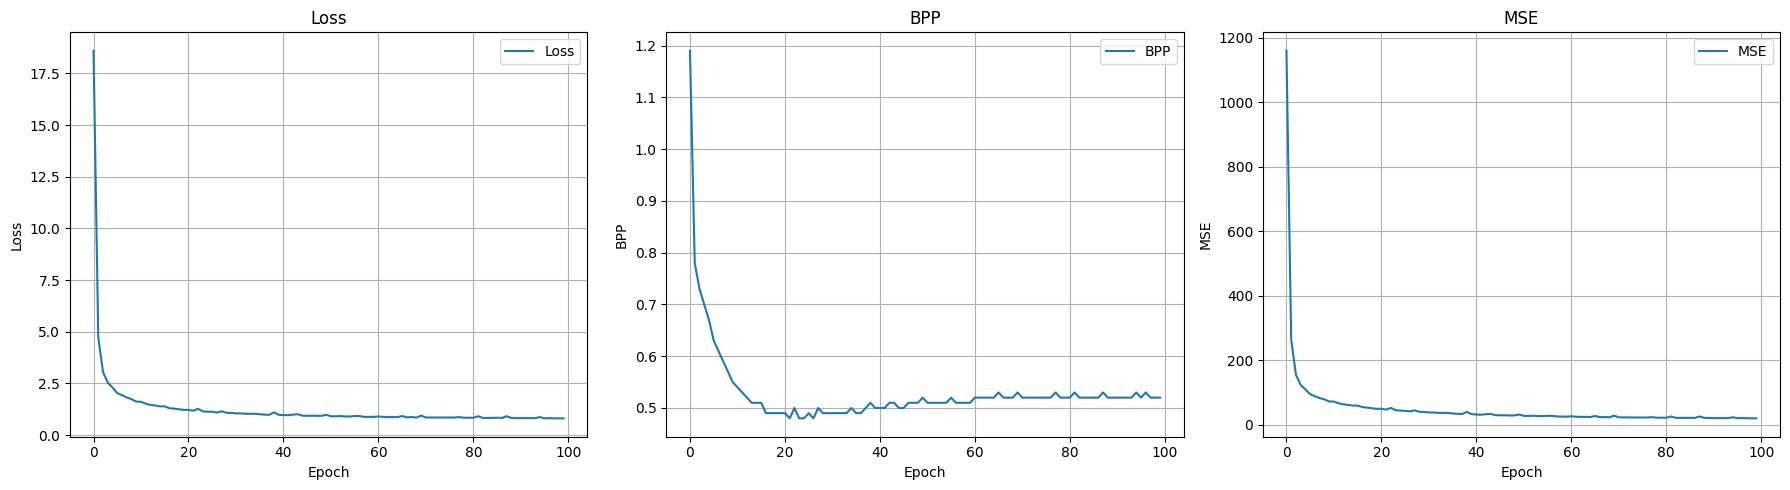

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Read data from txt files
train_losses = np.loadtxt('/content/drive/MyDrive/EE435/train_losses.txt')
train_bpps = np.loadtxt('/content/drive/MyDrive/EE435/train_bpps.txt')
train_mses = np.loadtxt('/content/drive/MyDrive/EE435/train_mses.txt')

# Create three subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Loss graph
axes[0].plot(train_losses, label='Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Plot BPP graph
axes[1].plot(train_bpps, label='BPP')
axes[1].set_title('BPP')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('BPP')
axes[1].grid(True)
axes[1].legend()

# Plot MSE graph
axes[2].plot(train_mses, label='MSE')
axes[2].set_title('MSE')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('MSE')
axes[2].grid(True)
axes[2].legend()

# Adjust the layout
plt.tight_layout()
# Show the plot
plt.show()


## Inference

Upon completing the training phase, we proceed to the inference stage. Our objective is to achieve video compression and decompression while minimizing information loss during the compression process. Therefore, we perform inference on all frames of the videos to obtain the final set of images.

In [ ]:

def setup_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--filepath", type=str,default ='/content/drive/MyDrive/EE435/checkpoint/checkpoint_best_loss_97.pth.tar', help="Path to the checkpoint model to be exported."
    )
    parser.add_argument("-n", "--name",default = 'checkpoint_last_change_97.pth.tar' , type=str, help="Exported model name.")
    parser.add_argument("-d", "--dir",default = '/content/drive/MyDrive/EE435/' , type=str, help="Exported model directory.")
    parser.add_argument(
        "--no-update",
        action="store_true",
        default=False,
        help="Do not update the model CDFs parameters.",
    )
    return parser


In [ ]:
import argparse
import sys

from pathlib import Path
import os


def main(argv):
    parser = setup_args()
    args, unknown = parser.parse_known_args()
    filepath = Path(args.filepath).resolve()
    if not filepath.is_file():
        raise RuntimeError(f'"{filepath}" is not a valid file.')

    state_dict = load_checkpoint(filepath)

    model_cls = TestModel()
    net = model_cls.from_state_dict(state_dict)


    if not args.no_update:
        net.update(force=True)
    state_dict = net.state_dict()

    if not args.name:
        filename = filepath
        while filename.suffixes:
            filename = Path(filename.stem)
    else:
        filename = args.name

    ext = "".join(filepath.suffixes)

    if args.dir is not None:
        output_dir = Path(args.dir)
        if not os.path.exists(args.dir):
            try:
                os.mkdir(args.dir)
            except:
                os.makedirs(args.dir)
        Path(output_dir).mkdir(exist_ok=True)
    else:
        output_dir = Path.cwd()

    filepath = output_dir / f"{filename}{ext}"
    torch.save(state_dict, filepath)



if __name__ == "__main__":
    main(sys.argv[1:])


In [ ]:
def setup_args():
    parser = argparse.ArgumentParser(description="Example training script.")

    # Common options.
    parser.add_argument("--dataset", type=str, default='/content/drive/MyDrive/EE435/train', help="dataset path")
    parser.add_argument(
        "--output_path", default='result',
        help="result output path",
    )
    parser.add_argument(
        "-c",
        "--entropy-coder",
        choices=compressai.available_entropy_coders(),
        default=compressai.available_entropy_coders()[0],
        help="entropy coder (default: %(default)s)",
    )
    parser.add_argument(
        "--cuda",
        action="store_true",
        help="enable CUDA",
    )
    parser.add_argument(
        "--half",
        action="store_true",
        help="convert model to half floating point (fp16)",
    )
    parser.add_argument(
        "--entropy-estimation",
        action="store_true",
        help="use evaluated entropy estimation (no entropy coding)",
    )
    parser.add_argument(
        "-p",
        "--path",
        dest="paths",
        type=str,
        default='/content/drive/MyDrive/EE435/checkpoint_last_change_97.pth.tar.pth.tar',
        help="checkpoint path",
    )
    parser.add_argument(
        "--patch",
        type=int,
        default=256,
        help="padding patch size (default: %(default)s)",
    )

    return parser

In [ ]:

"""
Evaluate an end-to-end compression model on an image dataset.
"""
import argparse
import json
import sys
import time
import csv

from collections import defaultdict
from typing import List
import torch.nn.functional as F
from PIL import Image
from pytorch_msssim import ms_ssim
from torchvision import transforms
import torchvision
import compressai
from compressai.zoo import load_state_dict
import torch
import os
import math
import torch.nn as nn
torch.backends.cudnn.deterministic = True
torch.set_num_threads(1)

# from torchvision.datasets.folder
IMG_EXTENSIONS = (
    ".jpg",
    ".jpeg",
    ".png",
    ".ppm",
    ".bmp",
    ".pgm",
    ".tif",
    ".tiff",
    ".webp",
)

def collect_images(rootpath: str) -> List[str]:
    return [
        os.path.join(rootpath, f)
        for f in os.listdir(rootpath)
        if os.path.splitext(f)[-1].lower() in IMG_EXTENSIONS
    ]

def psnr(a: torch.Tensor, b: torch.Tensor) -> float:
    mse = torch.nn.functional.mse_loss(a, b).item()
    return -10 * math.log10(mse)

def read_image(filepath: str) -> torch.Tensor:
    assert os.path.isfile(filepath)
    img = Image.open(filepath).convert("RGB")
    return transforms.ToTensor()(img)


@torch.no_grad()
def inference(model, x, f, outputpath, patch):
    x = x.unsqueeze(0)
    imgpath = f.split('/')
    imgpath[-2] = outputpath
    imgPath = '/'.join(imgpath)
    csvfile = '/'.join(imgpath[:-1]) + '/result.csv'
    print('decoding img: {}'.format(f))
########original padding
    h, w = x.size(2), x.size(3)
    p = patch  # maximum 6 strides of 2
    new_h = (h + p - 1) // p * p
    new_w = (w + p - 1) // p * p
    padding_left = 0
    padding_right = new_w - w - padding_left
    padding_top = 0
    padding_bottom = new_h - h - padding_top
    pad = nn.ConstantPad2d((padding_left, padding_right, padding_top, padding_bottom), 0)
    x_padded = pad(x)

    _, _, height, width = x_padded.size()
    start = time.time()
    out_enc = model.compress(x_padded)
    enc_time = time.time() - start

    start = time.time()
    out_dec = model.decompress(out_enc["strings"], out_enc["shape"])
    dec_time = time.time() - start

    out_dec["x_hat"] = torch.nn.functional.pad(
        out_dec["x_hat"], (-padding_left, -padding_right, -padding_top, -padding_bottom)
    )

    num_pixels = x.size(0) * x.size(2) * x.size(3)
    bpp = 0
    for s in out_enc["strings"]:
        for j in s:
            if isinstance(j, list):
                for i in j:
                    if isinstance(i, list):
                        for k in i:
                            bpp += len(k)
                    else:
                        bpp += len(i)
            else:
                bpp += len(j)
    bpp *= 8.0 / num_pixels
    # bpp = sum(len(s[0]) for s in out_enc["strings"]) * 8.0 / num_pixels
    z_bpp = len(out_enc["strings"][1][0])* 8.0 / num_pixels
    y_bpp = bpp - z_bpp

    torchvision.utils.save_image(out_dec["x_hat"], imgPath, nrow=1)
    PSNR = psnr(x, out_dec["x_hat"])
    with open(csvfile, 'a+') as f:
        row = [imgpath[-1], bpp * num_pixels, num_pixels, bpp, y_bpp, z_bpp,
               torch.nn.functional.mse_loss(x, out_dec["x_hat"]).item() * 255 ** 2, psnr(x, out_dec["x_hat"]),
               ms_ssim(x, out_dec["x_hat"], data_range=1.0).item(), enc_time, dec_time, out_enc["time"]['y_enc'] * 1000,
               out_dec["time"]['y_dec'] * 1000, out_enc["time"]['z_enc'] * 1000, out_enc["time"]['z_dec'] * 1000,
               out_enc["time"]['params'] * 1000]
        write = csv.writer(f)
        write.writerow(row)
    print('bpp:{}, PSNR: {}, encoding time: {}, decoding time: {}'.format(bpp, PSNR, enc_time, dec_time))
    return {
        "psnr": PSNR,
        "bpp": bpp,
        "encoding_time": enc_time,
        "decoding_time": dec_time,
    }

@torch.no_grad()
def inference_entropy_estimation(model, x, f, outputpath, patch):
    x = x.unsqueeze(0)
    imgpath = f.split('/')
    imgpath[-2] = outputpath
    imgPath = '/'.join(imgpath)
    csvfile = '/'.join(imgpath[:-1]) + '/result.csv'
    print('decoding img: {}'.format(f))
    ########original padding
    h, w = x.size(2), x.size(3)
    p = patch  # maximum 6 strides of 2
    new_h = (h + p - 1) // p * p
    new_w = (w + p - 1) // p * p
    padding_left = (new_w - w) // 2
    padding_right = new_w - w - padding_left
    padding_top = (new_h - h) // 2
    padding_bottom = new_h - h - padding_top
    x_padded = torch.nn.functional.pad(
        x,
        (padding_left, padding_right, padding_top, padding_bottom),
        mode="constant",
        value=0,
    )
    _, _, height, width = x_padded.size()


    start = time.time()
    out_net = model.inference(x_padded)


    elapsed_time = time.time() - start
    out_net["x_hat"] = torch.nn.functional.pad(
        out_net["x_hat"], (-padding_left, -padding_right, -padding_top, -padding_bottom)
    )
    num_pixels = x.size(0) * x.size(2) * x.size(3)
    bpp = sum(
        (torch.log(likelihoods).sum() / (-math.log(2) * num_pixels))
        for likelihoods in out_net["likelihoods"].values()
    )
    y_bpp = (torch.log(out_net["likelihoods"]["y"]).sum() / (-math.log(2) * num_pixels))
    z_bpp = (torch.log(out_net["likelihoods"]["y"]).sum() / (-math.log(2) * num_pixels))

    torchvision.utils.save_image(out_net["x_hat"], imgPath, nrow=1)
    PSNR = psnr(x, out_net["x_hat"])
    with open(csvfile, 'a+') as f:
        row = [imgpath[-1], bpp.item() * num_pixels, num_pixels, bpp.item(), y_bpp.item(), z_bpp.item(),
               torch.nn.functional.mse_loss(x, out_net["x_hat"]).item() * 255 ** 2, PSNR,
               ms_ssim(x, out_net["x_hat"], data_range=1.0).item(), elapsed_time / 2.0, elapsed_time / 2.0,
               out_net["time"]['y_enc'] * 1000, out_net["time"]['y_dec'] * 1000, out_net["time"]['z_enc'] * 1000,
               out_net["time"]['z_dec'] * 1000, out_net["time"]['params'] * 1000]
        write = csv.writer(f)
        write.writerow(row)
    return {
        "psnr": PSNR,
        "bpp": bpp.item(),
        "encoding_time": elapsed_time / 2.0,  # broad estimation
        "decoding_time": elapsed_time / 2.0,
    }


def eval_model(model, filepaths, entropy_estimation=False, half=False, outputpath='Recon', patch=576):
    device = next(model.parameters()).device
    metrics = defaultdict(float)
    imgdir = filepaths[0].split('/')
    imgdir[-2] = outputpath
    imgDir = '/'.join(imgdir[:-1])
    if not os.path.isdir(imgDir):
        os.makedirs(imgDir)
    csvfile = imgDir + '/result.csv'
    if os.path.isfile(csvfile):
        os.remove(csvfile)
    with open(csvfile, 'w') as f:
        row = ['name', 'bits', 'pixels', 'bpp', 'y_bpp', 'z_bpp', 'mse', 'psnr(dB)', 'ms-ssim', 'enc_time(s)', 'dec_time(s)', 'y_enc(ms)',
               'y_dec(ms)', 'z_enc(ms)', 'z_dec(ms)', 'param(ms)']
        write = csv.writer(f)
        write.writerow(row)
    for f in filepaths:
        x = read_image(f).to(device)
        if not entropy_estimation:
            if half:
                model = model.half()
                x = x.half()
            rv = inference(model, x, f, outputpath, patch)
        else:
            rv = inference_entropy_estimation(model, x, f, outputpath, patch)
        for k, v in rv.items():
            metrics[k] += v
    for k, v in metrics.items():
        metrics[k] = v / len(filepaths)
    return metrics


def main(argv):
    parser = setup_args()
    args, unknown = parser.parse_known_args()

    filepaths = collect_images(args.dataset)
    filepaths = sorted(filepaths)
    if len(filepaths) == 0:
        print("Error: no images found in directory.", file=sys.stderr)
        sys.exit(1)

    compressai.set_entropy_coder(args.entropy_coder)

    state_dict = load_state_dict(torch.load(args.paths))
    model_cls = TestModel()
    model = model_cls.from_state_dict(state_dict).eval()

    results = defaultdict(list)

    if args.cuda and torch.cuda.is_available():
        model = model.to("cuda")

    metrics = eval_model(model, filepaths, args.entropy_estimation, args.half, args.output_path, args.patch)
    for k, v in metrics.items():
        results[k].append(v)

    description = (
        "entropy estimation" if args.entropy_estimation else args.entropy_coder
    )
    output = {
        "description": f"Inference ({description})",
        "results": results,
    }
    print(json.dumps(output, indent=2))

if __name__ == "__main__":
    main(sys.argv[1:])


流式输出内容被截断，只能显示最后 5000 行内容。
bpp:0.45925925925925926, PSNR: 33.677461020830734, encoding time: 0.7219345569610596, decoding time: 0.6403744220733643
decoding img: /content/drive/MyDrive/EE435/train/frame_0019503510.png
bpp:0.4666666666666666, PSNR: 33.47560941088383, encoding time: 0.7050676345825195, decoding time: 0.6393744945526123
decoding img: /content/drive/MyDrive/EE435/train/frame_0019518629.png
bpp:0.4666666666666666, PSNR: 33.62014853895165, encoding time: 0.7002255916595459, decoding time: 0.6606128215789795
decoding img: /content/drive/MyDrive/EE435/train/frame_0019533748.png
bpp:0.45999999999999996, PSNR: 33.74700086755665, encoding time: 0.7210397720336914, decoding time: 0.6516714096069336
decoding img: /content/drive/MyDrive/EE435/train/frame_0019548867.png
bpp:0.44740740740740736, PSNR: 33.72176498055323, encoding time: 0.7250492572784424, decoding time: 0.6489334106445312
decoding img: /content/drive/MyDrive/EE435/train/frame_0019563986.png
bpp:0.45037037037037037, PSNR

Finally, we got the average PSNR as 33.20, with bpp as 0.488 and average 0.72 second for compression per frames and 0.65 second for decompressioin.  The image below compares the original data, the reconstructed image and the compressed and decompressed image.


  <center><b><font size=5>Source</b>

![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/events_0000015119.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/events_0019095297.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/events_0057132658.png?raw=true)

 <b><font size=5>Reconstruction</b>

![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/frame_0000015119.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/frame_0019095297.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/frame_0057132658.png?raw=true)
        
 <b><font size=5>Decompression</b>

![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/result_0000015119.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/rseult_0019095297.png?raw=true)
![](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/sample_images/result_0057132658.png?raw=true)
</center>


## Video Output
After processing all the frames, we have the final desired video which you can see in [yotube](https://) or download in [github](https://github.com/Bifei-Hao/EE435_Final_Project/blob/main/result/output_video.mp4)

In [20]:
import cv2
import os

# Define the directory containing the images
image_folder = '/content/drive/MyDrive/EE435/EE435/result'
video_name = '/content/drive/MyDrive/EE435/EE435/output_video.mp4'
# Get a list of image files in the directory
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()  # Ensure the images are sorted in the correct order

# Read the first image to get the dimensions
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the video codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_name, fourcc, 30, (width, height))

# Loop through all the images and write them to the video
for image in images:
    img_path = os.path.join(image_folder, image)
    frame = cv2.imread(img_path)
    video.write(frame)

# Release the VideoWriter object
video.release()
cv2.destroyAllWindows()
